# **Datathon - Proyecto Individual 2**
## Daniel Vallejos

# **Estancia hospitalaria**
Un importante Centro de Salud lo ha contratado con el fin de poder predecir si un paciente tendrá una estancia hospitalaria prolongada o no, utilizando la información contenida en el dataset asociado, la cual recaba una muestra histórica de sus pacientes, para poder administrar la demanda de camas en el hospital según la condición de los pacientes recientemente ingresados.

Para esto, se define que un paciente posee estancia hospitalaria prolongada si ha estado hospitalizado más de 8 días. Por lo que debe generar dicha variable categórica y luego categorizar los pacientes según las variables que usted considere necesarias, justificando dicha elección.​

# **EDA - Análisis Exploratorio de los Datos**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

from xgboost import XGBClassifier

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.inspection import permutation_importance

from sklearn.feature_selection import f_regression

from scipy.stats import loguniform

from sklearn import set_config

#from feature_engine.selection import DropFeatures, DropConstantFeatures, DropDuplicateFeatures

In [3]:
df_hos = pd.read_csv("./datasets/hospitalizaciones_train.csv")

In [4]:
#Cantidad de registros y columnas
df_hos.shape

(410000, 15)

In [5]:
#Estructura del Dataframe
df_hos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410000 entries, 0 to 409999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  410000 non-null  int64  
 1   Department                         410000 non-null  object 
 2   Ward_Facility_Code                 410000 non-null  object 
 3   doctor_name                        410000 non-null  object 
 4   staff_available                    410000 non-null  int64  
 5   patientid                          410000 non-null  int64  
 6   Age                                410000 non-null  object 
 7   gender                             410000 non-null  object 
 8   Type of Admission                  410000 non-null  object 
 9   Severity of Illness                410000 non-null  object 
 10  health_conditions                  410000 non-null  object 
 11  Visitors with Patient              4100

In [6]:
df_hos.head()

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,None,4,No,4814.149231,8
4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,34


In [7]:
#Función para analizar diferentes aspectos de un dataframe a nivel de estructura y datos
def analyse_df(df, corr_limit = 0.75):
    """Analyse any dataframe and print results
    * Muestra cantidad de filas y columnas, cantidad de filas duplicadas, tamaño, tipos de datos
    * Chequea valores nulos
    * Chequea la correlación entre columnas. Por defecto: 0.75 para definir si existe relación
    """   

    print('Información General:')
    print(f'{df.shape[0]} Rows {df.shape[1]} Columnas'
          f'\n{df.duplicated().sum()} Filas duplicadas'
          f'\nTamaño: {df.memory_usage().sum()/(1024*1024):.2f}Mb')
    
    # Chequeando Data Types
    int_list, float_list,object_list,bool_list,other_list =[[] for i in range(5)]
    for col in df.columns:
        if df[col].dtype == 'int64':
            int_list.append(col)
        elif df[col].dtype == 'float64':
            float_list.append(col)
        elif df[col].dtype == 'object':
            object_list.append(col)
        elif df[col].dtype == 'boolean':
            bool_list.append(col)
        else:
            other_list.append(col)
            
    for type_list,data_type in zip([int_list, float_list,object_list,bool_list,other_list],
                                   ['int64','float64','object','boolean','other']):
        if len(type_list)>0:
            print(f'\nColumns {data_type}: {type_list}')
            
    # Info General
    display(df.describe())
    
    # Chequeando valores nulos
    print('\nChequeando valores nulos:')
    col_with_missing_counter = 0
    for col in df.columns:
        qnt_missing = df[col].isna().sum()
        if qnt_missing > 0:
            col_with_missing_counter +=1
            print(f'La columna "{col}" tiene {qnt_missing} nulos ({qnt_missing/df.shape[0]:.2%})')
    if col_with_missing_counter ==0 :
        print('El DataFrame no tiene nulos')
        
    # Chequeando la correlación lineal entre columnas
    print('\nChequeando la Correlation:')
    df_corr = df.corr() 
    ckecked_list =[] 
    cols_with_correlation_counter = 0
    for col in df_corr.columns:
        ckecked_list.append(col)
        for i in range(len(df_corr)):
            if ((df_corr[col][i] > corr_limit or df_corr[col][i] < -corr_limit) and
                (df_corr.index[i] not in ckecked_list)):
                cols_with_correlation_counter += 1
                print(f'Se encontró correlación entre las columnas '
                      f'{df_corr.index[i]} and {col} -> Pearson coef. = {df_corr[col][i]:.2f}')         
    if cols_with_correlation_counter == 0:
        print('No se encontró correlación')

In [8]:
analyse_df(df_hos)

Información General:
410000 Rows 15 Columnas
0 Filas duplicadas
Tamaño: 46.92Mb

Columns int64: ['Available Extra Rooms in Hospital', 'staff_available', 'patientid', 'Visitors with Patient', 'Stay (in days)']

Columns float64: ['Admission_Deposit']

Columns object: ['Department', 'Ward_Facility_Code', 'doctor_name', 'Age', 'gender', 'Type of Admission', 'Severity of Illness', 'health_conditions', 'Insurance']


,Available Extra Rooms in Hospital,staff_available,patientid,Visitors with Patient,Admission_Deposit,Stay (in days)
count,410000.000000,410000.000000,410000.000000,410000.000000,410000.000000,410000.000000
mean,3.639376,5.020946,63095.940020,3.552520,4723.419239,12.378193
std,2.701702,3.158018,41686.175937,2.247459,1047.420292,7.905618
min,0.000000,0.000000,-3146.000000,0.000000,1654.005148,3.000000
25%,2.000000,2.000000,25405.000000,2.000000,4072.638351,8.000000
50%,3.000000,5.000000,57736.000000,3.000000,4627.488745,9.000000
75%,4.000000,8.000000,103278.250000,4.000000,5092.349430,11.000000
max,24.000000,10.000000,134400.000000,32.000000,10104.726390,51.000000



Chequeando valores nulos:
El DataFrame no tiene nulos

Chequeando la Correlation:
No se encontró correlación


**Analizando las columnas**: las siguientes columnas se van a descartar


*   La columna: Ward_Facility_Code, número de habitación, no es representativa para este modelo, por sentido común.
*   La columna: Available Extra Rooms in Hospital, cantidad de habitaciones extras, no es representativa para este modelo.
*   La columna: staff_available, personal disponible, no es representativa para este modelo.
*   La columna: patientid, ID del paciente, no es representativa para este modelo por sentido común.
*   La columna: Visitors with Patient, cantidad de personas que visitaron al paciente, no es representativa para este modelo por sentido común, es un dato que se va alimentando con el paso del tiempo y no al ingreso.


In [9]:
#df_hos.doctor_name.value_counts()
#df_hos.Age.value_counts()
#df_hos.gender.value_counts()
#df_hos['Type of Admission'].value_counts()
#df_hos['Severity of Illness'].value_counts()
#df_hos.health_conditions.value_counts()
#df_hos.Insurance.value_counts()
df_hos.Department.value_counts()

gynecology            281625
radiotherapy           69132
anesthesia             36250
TB & Chest disease     18825
surgery                 4168
Name: Department, dtype: int64

# **Transformación de Datos**
Se realiza adecuación de los datos para luego poder utilizarlos en el modelo

In [10]:
#Creo que la columna target: asigno valor 1 a todos los registros que tienen más de 8 en el el campo Stay (in days)
df_hos['EHP'] = df_hos['Stay (in days)'].apply(lambda x: 1 if x > 8 else 0 )

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


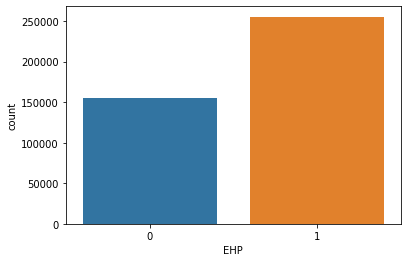

In [11]:
sns.countplot(df_hos['EHP'],label="Cantidad")

In [16]:
#Proporción registros con Estancia Hospitalaria Prolongada
cantidad_si_EHP = len(df_hos[df_hos['EHP']==1])
cantidad_no_EHP = len(df_hos[df_hos['EHP']==0])
pct_de_no = cantidad_no_EHP / (cantidad_no_EHP + cantidad_si_EHP)
print("porcentaje de pacientes sin EHP", round(pct_de_no*100,2))
pct_de_si = cantidad_si_EHP / (cantidad_no_EHP + cantidad_si_EHP)
print("porcentaje de pacientes con EHP", round(pct_de_si * 100,2))

porcentaje de pacientes sin EHP 37.7
porcentaje de pacientes con EHP 62.3


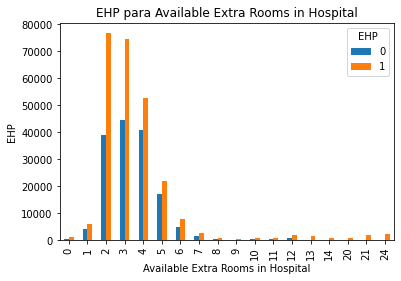

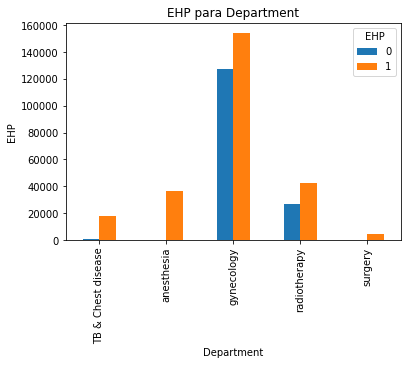

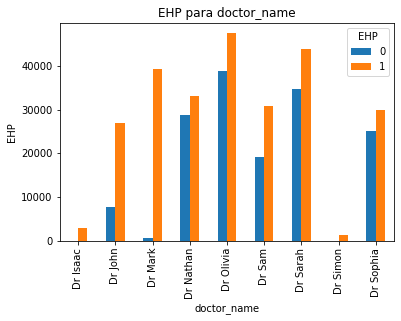

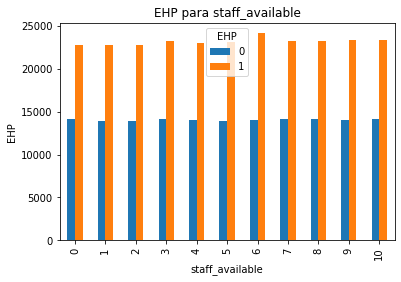

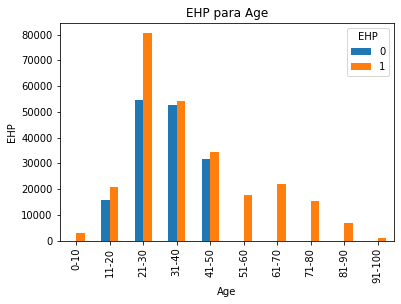

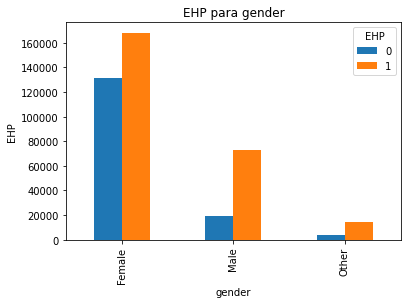

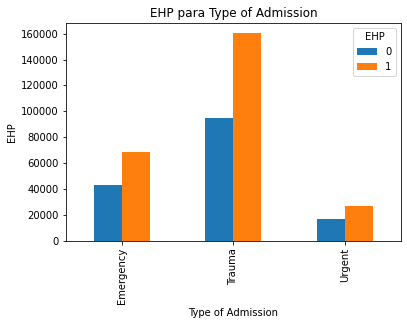

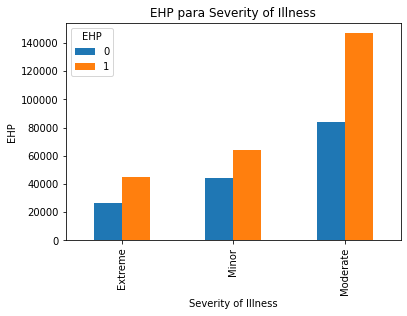

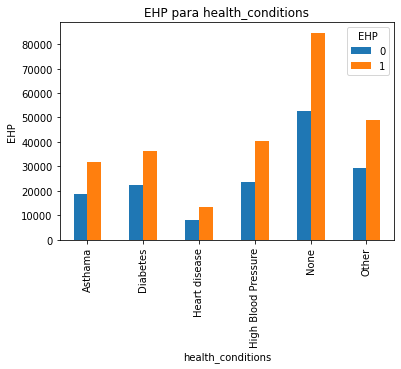

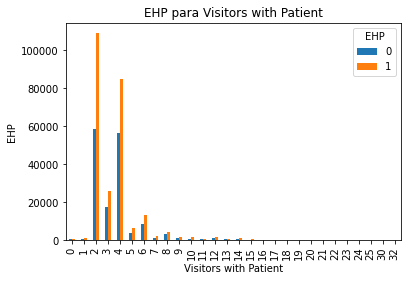

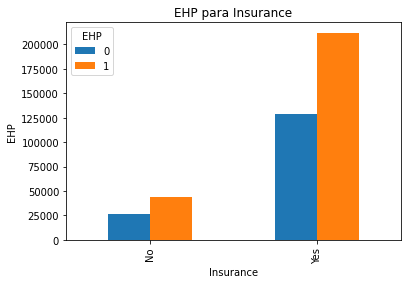

In [17]:
# Grafico para observar la relación de cada columna con la columna objetivo
for i in df_hos[['Available Extra Rooms in Hospital', 'Department', 'doctor_name', 'staff_available', 'Age', 'gender', 'Type of Admission', 'Severity of Illness', 'health_conditions',
       'Visitors with Patient', 'Insurance']].columns:
        
        #%matplotlib inline
        pd.crosstab(df_hos[i], df_hos.EHP).plot(kind='bar')
        plt.title('EHP para ' + i)
        plt.xlabel(i)
        plt.ylabel('EHP')

In [18]:
#Normalizo nombres de columnas, todos en minúsculas y reemplazo espacios en blanco por guión bajo
df_hos.columns = [k.lower().replace(" ", "_") for k in df_hos.columns]

In [19]:
#elimino la columna stay in days luego de haber generado la columna target para el modelo
df_hos.drop(columns=["stay_(in_days)"], inplace=True)

In [20]:
#cambio el tipo de dato a category todos los que son object (strings)
df_hos[df_hos.select_dtypes(['object']).columns] = df_hos.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [ ]:
#df_hos.drop(columns=['age_0_10', 'age_11_20', 'age_21_30', 'age_31_40', 'age_41_50', 'age_51_60', 'age_61_70', 'age_71_80', 'age_81_90', 'age_91_100'], inplace=True)

In [21]:
df_hos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410000 entries, 0 to 409999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   available_extra_rooms_in_hospital  410000 non-null  int64   
 1   department                         410000 non-null  category
 2   ward_facility_code                 410000 non-null  category
 3   doctor_name                        410000 non-null  category
 4   staff_available                    410000 non-null  int64   
 5   patientid                          410000 non-null  int64   
 6   age                                410000 non-null  category
 7   gender                             410000 non-null  category
 8   type_of_admission                  410000 non-null  category
 9   severity_of_illness                410000 non-null  category
 10  health_conditions                  410000 non-null  category
 11  visitors_with_patient     

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
df_hos.age.values

['41-50', '31-40', '21-30', '31-40', '71-80', ..., '31-40', '21-30', '21-30', '21-30', '41-50']
Length: 410000
Categories (10, object): ['0-10', '11-20', '21-30', '31-40', ..., '61-70', '71-80', '81-90', '91-100']

In [ ]:
#Creo una nueva columna para el rango de edades utilizando OrdinalEncoder
enc = OrdinalEncoder()
valores = df_hos.age.values.reshape(-1,1)
enc.fit(valores)
valores_endcoded = enc.transform(valores)
print( enc.categories_ )

In [ ]:
#df_hos['age_encoded'] = valores_endcoded[:,0]

In [ ]:
'''
fig, ax = plt.subplots(figsize=(20,20))
corr = df_x2.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        ax=ax);
'''

In [ ]:
df_x2 = df_hos[[
    'dep_TB&Chest', 'dep_anesthesia', 'dep_radiotherapy', 'dep_surgery',
    'age_encoded',
    'gen_male', 'gen_female', 'gen_other',
    'type_Emergency', 'type_Trauma', 'type_Urgent',
    'sev_Extreme', 'sev_Minor', 'sev_Moderate',
    'hcon_Asthama', 'hcon_Diabetes', 'hcon_Heart_disease', 'hcon_High_Blood_Pressure', 'hcon_None', 'hcon_Other',
    'ins_no', 'ins_yes',
    'Available Extra Rooms in Hospital','staff_available',
    'Admission_Deposit',
    'EHP']]

#    'Admission_Deposit',
#    'dep_TB&Chest', 'dep_anesthesia', 'dep_gynecology', 'dep_radiotherapy', 'dep_surgery',
#    'age_0_10', 'age_11_20', 'age_21_30', 'age_31_40', 'age_41_50', 'age_51_60', 'age_61_70', 'age_71_80', 'age_81_90', 'age_91_100',


In [ ]:
#df_x2 = df_hos[['dep_anesthesia', 'dep_surgery', 'age_encoded','gen_male','gen_female','gen_other','EHP']]

# **Corriendo Modelos de ML**
Se divide el set de datos en entrenamiento y test (20%)

In [22]:
#Defino la columnas para las variables independientes y dependiente
X = df_hos[['department', 'age', 'gender', 'type_of_admission', 'severity_of_illness', 'health_conditions', 'insurance', 'admission_deposit']]
y = df_hos['ehp']

In [23]:
#Split test del 20%
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
'''
#Standarizo los valores usando StandardScaler
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)
'''

## Modelo: Arbol de Decisión

In [ ]:
clf = DecisionTreeClassifier(max_depth = 9, random_state = 42)

In [ ]:
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=9, random_state=42)

In [ ]:
print("Accuracy on training set: {:.3f}".format(clf.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(clf.score(x_test, y_test)))

Accuracy on training set: 0.712
Accuracy on test set: 0.712


In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.40      0.51     31078
           1       0.71      0.90      0.80     50922

    accuracy                           0.71     82000
   macro avg       0.71      0.65      0.65     82000
weighted avg       0.71      0.71      0.69     82000



## Modelo Gradient Boosting

In [ ]:
gb = GradientBoostingClassifier(random_state=0)
gb.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(gb.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb.score(x_test, y_test)))

Accuracy on training set: 0.718
Accuracy on test set: 0.717


In [ ]:
y_pred = gb.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.44      0.54     31078
           1       0.72      0.89      0.80     50922

    accuracy                           0.72     82000
   macro avg       0.71      0.66      0.67     82000
weighted avg       0.71      0.72      0.70     82000



In [ ]:
accuracy_score(y_test, y_pred)

0.7172804878048781

In [ ]:
recall_score(y_test, y_pred, average= None)

array([0.43867044, 0.88731786])

## Modelo Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(rf.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(x_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.729


In [ ]:
y_pred = rf.predict(x_test)

In [ ]:
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred, average= None))
print(classification_report(y_test, y_pred))

0.7288658536585366
[0.6326702  0.78722862]
              precision    recall  f1-score   support

           0       0.64      0.63      0.64     30964
           1       0.78      0.79      0.78     51036

    accuracy                           0.73     82000
   macro avg       0.71      0.71      0.71     82000
weighted avg       0.73      0.73      0.73     82000



## Modelo SVC

In [ ]:
clf = SVC(kernel='poly', random_state=0)
clf.fit(x_train, y_train)

SVC(kernel='poly', random_state=0)

In [ ]:
print("Accuracy on training set: {:.3f}".format(clf.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(clf.score(x_test, y_test)))

Accuracy on training set: 0.696
Accuracy on test set: 0.683


In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred, average= None))
print(classification_report(y_test, y_pred))

0.6826829268292683
[0.24674055 0.94329696]
              precision    recall  f1-score   support

           0       0.72      0.25      0.37      3068
           1       0.68      0.94      0.79      5132

    accuracy                           0.68      8200
   macro avg       0.70      0.60      0.58      8200
weighted avg       0.69      0.68      0.63      8200



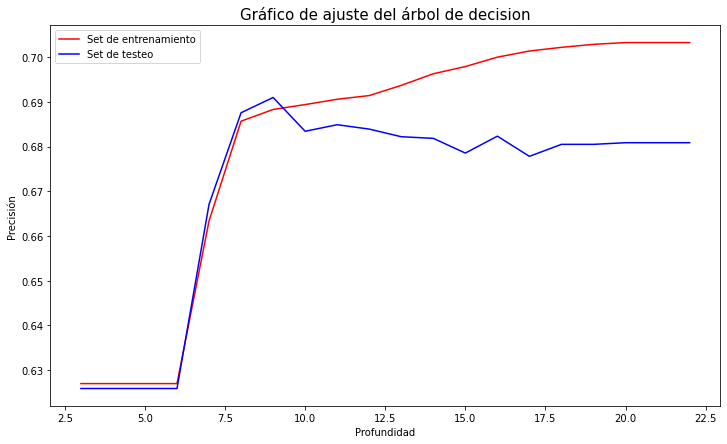

In [ ]:
train_prec =  []
eval_prec = []
max_deep_list = list(range(3, 23))

for deep in max_deep_list:
    clf_3 = DecisionTreeClassifier(max_depth=deep, criterion='entropy')
    clf_3.fit(x_train, y_train)
    train_prec.append(clf_3.score(x_train, y_train))
    eval_prec.append(clf_3.score(x_test, y_test))

plt.figure(figsize=(12,7))
plt.plot(max_deep_list, train_prec, color='r', label='Set de entrenamiento')
plt.plot(max_deep_list, eval_prec, color='b', label='Set de testeo')
plt.title('Gráfico de ajuste del árbol de decision', fontsize = 15)
plt.legend()
plt.ylabel('Precisión')
plt.xlabel('Profundidad')
plt.show()

## Modelo Regresión Logística

In [ ]:
log_clf = LogisticRegression()

In [ ]:
log_clf.fit(x_train, y_train)

LogisticRegression()

In [ ]:
y_pred = log_clf.predict(x_test)

In [ ]:
print("Accuracy on training set: {:.3f}".format(log_clf.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(log_clf.score(x_test, y_test)))

Accuracy on training set: 0.590
Accuracy on test set: 0.589


In [ ]:
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred, average= None))
print(classification_report(y_test, y_pred))

0.5893048780487805
[0.26588942 0.78552394]
              precision    recall  f1-score   support

           0       0.43      0.27      0.33     30964
           1       0.64      0.79      0.70     51036

    accuracy                           0.59     82000
   macro avg       0.53      0.53      0.52     82000
weighted avg       0.56      0.59      0.56     82000



In [ ]:
#from sklearn.feature_selection import f_regression 

In [ ]:
x = df_x2[df_x2.columns[1:].tolist()]
f_stats_values = f_regression(x,y)[0]
p_values = f_regression(x,y)[1] #para obter somente os p_values

f_regression_df = pd.DataFrame({'Feature':df_x2.columns[1:].tolist(),
                                'f_statistic' : f_stats_values,
                                'p_values':p_values
                               })

f_regression_df

## Modelo XGBoost

In [ ]:
#from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier()

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
print("Accuracy on training set: {:.3f}".format(model.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(x_test, y_test)))

Accuracy on training set: 0.712
Accuracy on test set: 0.710


In [ ]:
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred, average= None))
print(classification_report(y_test, y_pred))

0.7096707317073171
[0.41576034 0.88904599]
              precision    recall  f1-score   support

           0       0.70      0.42      0.52     31078
           1       0.71      0.89      0.79     50922

    accuracy                           0.71     82000
   macro avg       0.70      0.65      0.66     82000
weighted avg       0.71      0.71      0.69     82000



In [ ]:
y_pred_tran = y_pred

In [ ]:
y_pred_tran

array([1, 1, 1, ..., 1, 1, 1])

## Construyo Pipeline

In [24]:
#Pipeline para tratar las columnas categóricas y numéricas

cat_steps = [('OHE', OneHotEncoder(drop='first', handle_unknown='ignore'))]

pipe_cat = Pipeline(cat_steps)

num_steps = [('scale', StandardScaler()) ]

pipe_num = Pipeline(num_steps)

In [25]:
# Nombres de las variables categóricas
categorical_vars = X.select_dtypes('category').columns.tolist()

# Nombres de las variables numéricas
numerical_vars = X.select_dtypes('number').columns.tolist()

# Creando multilayer pipe
one_pipe = ColumnTransformer(transformers=[
          ('numbers', pipe_num, numerical_vars),
          ('categories', pipe_cat, categorical_vars) ] )

In [26]:
# Pipes para los modelos

pipe_lr = Pipeline([('pre', one_pipe),
			('clf', LogisticRegression(random_state=42))])


pipe_xgb = Pipeline([('pre', one_pipe ),
			('clf', XGBClassifier(random_state=42))])
			
pipe_dt = Pipeline([('pre', one_pipe ),
			('clf', tree.DecisionTreeClassifier(random_state=42))])

pipelines = [pipe_lr, pipe_xgb, pipe_dt]

pipe_dict = {0: 'Regresión Logística', 1: 'XGB', 2: 'Árbol de decisión'}

In [27]:
#Se entrena con cada modelo de la lista
for pipe in pipelines:
	pipe.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
#observando los resultados
for idx, val in enumerate(pipelines):
	print('%s pipeline accuracy en test: %.3f' % (pipe_dict[idx], val.score(x_test, y_test)))

Regresión Logística pipeline accuracy en test: 0.656
XGB pipeline accuracy en test: 0.703
Árbol de decisión pipeline accuracy en test: 0.700


In [29]:
# Identificamos el mejor modelo para el set de testeo
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
	if val.score(x_test, y_test) > best_acc:
		best_acc = val.score(x_test, y_test)
		best_pipe = val
		best_clf = idx
print('Modelo con el mejor accuracy: %s' % pipe_dict[best_clf])

Modelo con el mejor accuracy: XGB


In [30]:
y_pred = pipelines[best_clf].predict(x_test)

In [31]:
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred, average= None))
print(classification_report(y_test, y_pred))

0.7027073170731707
[0.30353647 0.94099089]
              precision    recall  f1-score   support

           0       0.75      0.30      0.43     30652
           1       0.69      0.94      0.80     51348

    accuracy                           0.70     82000
   macro avg       0.72      0.62      0.62     82000
weighted avg       0.72      0.70      0.66     82000



In [32]:
pipelines[best_clf]

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numbers',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['admission_deposit']),
                                                 ('categories',
                                                  Pipeline(steps=[('OHE',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['department', 'age',
                                                   'gender',
                                                   'type_of_admission',
                                                   'severity_of_illness',
                                                   'hea

## Ajusto dataset de test con los cambios

In [33]:
df_hos_t = pd.read_csv("./datasets/hospitalizaciones_test.csv")

In [34]:
df_hos_t.columns = [k.lower().replace(" ", "_") for k in df_hos_t.columns]

In [35]:
df_hos_t[df_hos_t.select_dtypes(['object']).columns] = df_hos_t.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [ ]:
'''
enc = OrdinalEncoder()
valores = df_hos_t.age.values.reshape(-1,1)
enc.fit(valores)
valores_endcoded = enc.transform(valores)
print( enc.categories_ )
'''

In [ ]:
#df_hos_t['age_encoded'] = valores_endcoded[:,0]

In [ ]:
'''
df_x2_t = df_hos_t[[
    'dep_TB&Chest', 'dep_anesthesia', 'dep_radiotherapy', 'dep_surgery',
    'age_encoded',
    'gen_male', 'gen_female', 'gen_other',
    'type_Emergency', 'type_Trauma', 'type_Urgent',
    'sev_Extreme', 'sev_Minor', 'sev_Moderate',
    'hcon_Asthama', 'hcon_Diabetes', 'hcon_Heart_disease', 'hcon_High_Blood_Pressure', 'hcon_None', 'hcon_Other',
    'ins_no', 'ins_yes',
    'Available Extra Rooms in Hospital','staff_available',
    'Admission_Deposit',
    ]]
'''

In [37]:
df_x2_t = df_hos_t[['department', 'age', 'gender', 'type_of_admission', 'severity_of_illness', 'health_conditions', 'insurance', 'admission_deposit']]

In [39]:
#y_pred_test = model.predict(df_x2_t.values)
#y_pred_test = pipelines[best_clf].predict(df_x2_t.values)
y_pred_test = pipelines[best_clf].predict(df_x2_t)

In [40]:
df_pred = pd.DataFrame()
df_pred['pred'] = y_pred_test

In [41]:
df_pred.to_csv('./odvallejos(1).csv', index=False)